In [1]:
import re
import string 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from geopy.geocoders import Nominatim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

C:\Users\user\anaconda3\envs\mda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# NLTK Resource
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') # for tagging
nltk.download('stopwords') # stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-dat

True

In [3]:
# Import data
data = pd.read_csv('../data/reddit_heatwaves_comment.csv', sep = ';')

**<font color='green'>Text cleaning</font>**

In [4]:
# Helper function: Convert NLTK tag to WordNet tag because we're uring WordNet lemmatizer
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    
    elif tag.startswith('V'):
        return wordnet.VERB

    elif tag.startswith('N'):
        return wordnet.NOUN
    
    elif tag.startswith('R'):
        return wordnet.ADV

    else:
        return None

<font color='green'>In reddit, it is very common to see comments containing stop words which are not included in *NLTK*, *for example: dude, bro, something, yeah...* Reasonable to add some extra stop words.</font>

In [5]:
# Manually designed stop words
stop_words_manual = ['something', 'dude', 'one', 'people', 'time', 'month', 'year', 'day', 'yeah', 'right', 'thing', 
                     'bro', 'point', 'comment', 'someone']
stop_words = set(stopwords.words('english') + stop_words_manual)

In [6]:
# Remove unusual symbols, emoji, hyperlinks, and do lemmatization
class comment_cleaner():
    def __init__(self, data):
        self.data = data
        self.wordnet_lemmatizer = WordNetLemmatizer()
        
    def preprocessing(self, comment):
        comment = comment.lower()
        comment = re.sub(r'https*\S+', ' ', comment) # Remove hyperlink
        comment = re.sub(r'@\S+', ' ', comment) # Remove tagged username
        comment = re.sub(r'#\S+', ' ', comment) # Remove tagged word
        comment = re.sub(r'&\S+', ' ', comment) # Remove emoji
        comment = re.sub(r'’', '\'', comment) # Proper apostrophe
        comment = re.sub(r'°', '', comment) # Temperature "degree" notation
        comment = re.sub(r'//', '', comment) # Slash
        comment = re.sub(r'[\n]', ' ', comment) # Escape
        comment = re.sub('[%s]' % re.escape(string.punctuation.replace('\'', '')), '', comment) # Punctuation
        comment = comment.encode('utf-8', 'ignore').decode() # Uniform encoding
        return comment
    
    def lemmatization(self, comment):
        words = []
        tagging_nltk = nltk.pos_tag(word_tokenize(comment)) # pos tagging using NLTK
        tagging_nltk = [*map(lambda s: (s[0], get_wordnet_pos(s[1])), tagging_nltk)]
        tagging_nltk = [s for s in tagging_nltk if s[0] not in stop_words]
        
        # Since we are interested in the trend, we focus on topic modeling with noun and adjective
        for word, tag in tagging_nltk:
            if tag in [wordnet.NOUN ,wordnet.ADJ]:
                words.append(self.wordnet_lemmatizer.lemmatize(word, pos = tag))
        return ' '.join(words)
    
    def clean(self):
        self.data['comment_cleaned'] = self.data['comment'].apply(lambda s: self.lemmatization(self.preprocessing(s)))
        return self.data

In [7]:
# Clean data
Cleaner = comment_cleaner(data)
data = Cleaner.clean()

**<font color='green'>What countries/cities are the most mentioned?</font>**

<font color='green'> **Code Citation** </font>

<font color='green'> Cities shall not be omitted but there is **no** standard way to extract city names from a text. Entity recognition methods  provided by NLTK and Spacy are not robust to certain names and lower cases. We rely on the solution provided in the following post in StackOverflow to resolve the problem.</font>

https://stackoverflow.com/questions/59956670/parsing-city-of-origin-destination-city-from-a-string

In [8]:
# From StackOverflow
import requests
import json

# First data source
cities_url = 'https://pkgstore.datahub.io/core/world-cities/world-cities_json/data/5b3dd46ad10990bca47b04b4739a02ba/world-cities_json.json'
cities_json = json.loads(requests.get(cities_url).content.decode('utf8'))

countries1 = set([city['country'] for city in cities_json])
cities1 = set([city['name'] for city in cities_json])

In [9]:
# From StackOverflow
from flashtext import KeywordProcessor

keyword_processor = KeywordProcessor(case_sensitive=False)
keyword_processor.add_keywords_from_list(sorted(countries1))
keyword_processor.add_keywords_from_list(sorted(cities1))

In [10]:
# Store locations and their frequency in a dictionary
locations = dict()
for comment in data['comment_cleaned']:
    list_temp = keyword_processor.extract_keywords(comment)
    if len(list_temp) > 0:
        for location in list_temp:
            if location not in locations.keys():
                locations[location] = 1
            else:
                locations[location] += 1

In [11]:
# Manually filter non-related locations
remove_keys = ['Holiday', 'Tire', 'Normal', 'Central', 'Much', 'Manage', 'Man', 'Buy', 'Bath', 'Best', 'Nice', 'Reading', 'Un', 'Fountain',
              'Pop', 'Born', 'Union', 'Wedding', 'Bay', 'Young', 'Asia', 'Sake', 'March', 'Green', 'Liberal', 'Van', 'Salt', 'Mobile', 
               'Retreat', 'Bear', 'Opportunity', 'Police', 'Humble', 'Bra', 'Sale', 'University', 'Surprise', 'Superior', 'Pace', 'Bar', 'Mon', 
               'Terrace', 'Auch', 'Peer', 'Gay', 'Vite', 'Seaside', 'Split', 'Male', 'Mach', 'Gap', 'Prospect', 'Alot', 'Date', 'Sunset', 
               'Paradise', 'Boom', 'Reservoir', 'Alliance', 'Eagle', 'Wer', 'Ho', 'Sur']
for key in remove_keys:
    del locations[key]

In [12]:
# Convert city to country
geolocator = Nominatim(user_agent = 'mda')
countries = dict()

for city in list(locations.keys()):
    country = geolocator.geocode(city, language = 'en')[0].split(',')[-1].strip()
    countries[city] = country

In [13]:
# Count country frequency, use 'countries' as a key mapper 
countries_freq = dict()
for key in locations.keys():
    if countries[key] not in countries_freq.keys():
        countries_freq[countries[key]] = locations[key]
    else:
        countries_freq[countries[key]] += locations[key]

In [14]:
# Convert the results to a sorted series
countries_freq = pd.Series(countries_freq).sort_values(ascending = False)

In [15]:
# List European countries with frequency > 10
euro_list = ['France', 'Germany', 'Spain', 'Italy', 'United Kingdom', 'Sweden', 'Netherlands', 
             'Portugal', 'Ireland', 'Russia', 'Norway', 'Belgium', 'Poland', 'Switzerland', 
             'Denmark', 'Greece', 'Finland']

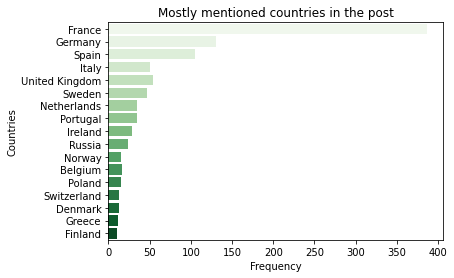

In [16]:
# Bar plot of the frequencies
data_temp = pd.DataFrame({'Count': countries_freq[euro_list]}).reset_index()
ax = sns.barplot(x = 'Count', y = 'index', data = data_temp, palette = 'Greens')
ax.set(xlabel = 'Frequency', ylabel = 'Countries', title = 'Mostly mentioned countries in the post');

**<font color='green'>What are the topic for the post?</font>**

- <font color='green'>The reason for using *gensim* instead of *scikit-learn* is because *gensim* provides the coherence scores which allows us to tune the number of topics</font>

In [17]:
# Create tokens for gensim models
def tokenize_comments(comments):
    comments_tonkenized = []

    for comment in comments:
        sentence = []
        
        for word in word_tokenize(comment):
            if word not in stop_words: # There may be stop words after lemmatization
                sentence.append(word) 
        comments_tonkenized.append(sentence)
        
    return comments_tonkenized

In [18]:
# Use cleaned comments to create tokens
comments_tonkenized = tokenize_comments(data['comment_cleaned'])

# Create dictionary and corpus - (token_id, token_count)
dictionary = corpora.Dictionary(comments_tonkenized)
dictionary.filter_extremes(no_above = 0.8) # Avoid common token
corpus = [dictionary.doc2bow(token) for token in comments_tonkenized]

In [26]:
# Train LDA models, and assess the performance using coherence scores
# Seed is needed because the LDA model changes the results when we rerun the script
SEED = 20210526
coherence_scores = []

for n_topics in np.arange(1, 15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = n_topics, id2word = dictionary, 
                                               iterations = 1000, random_state = SEED)
    ldamodel_coherence = CoherenceModel(model = ldamodel, texts = comments_tonkenized, dictionary = dictionary, 
                                        coherence ='c_v')
    coherence_scores.append(ldamodel_coherence.get_coherence())

**<font color='green'>Based on the coherence score, we should use 8 topics.</font>**

Text(0.5, 1.0, 'The performance of LDA model')

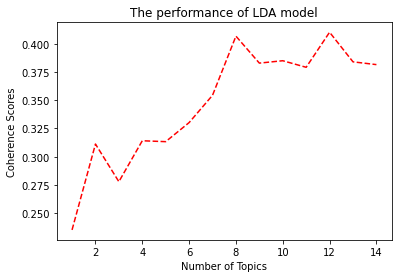

In [28]:
# Highest coherence_scores when number of topics is chosen to be 4
plt.plot(np.arange(1, 15), coherence_scores, 'r--')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.title('The performance of LDA model')

In [29]:
# Chosen model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 8, id2word = dictionary, 
                                           iterations = 1000, random_state = SEED)

**<font color='green'>What are the interpretations of the topic?</font>**

- <font color='green'>*Topic 0*: It is related to setting air conditioning units in summer, good, and inefficient energy.</font>
- <font color='green'>*Topic 1*: It is related to opinions on the patterns of the climate change in the world and human.</font>
- <font color='green'>*Topic 2*: It is related to good behavior, group of people under heatwaves and money.</font>
- <font color='green'>*Topic 3*: It is related to air conditioning/HVAC in the summer for house and places, bad, and old people.</font>
- <font color='green'>*Topic 4*: It is related to window, fan in the summer, want cooler and anger, outside is hot.</font>
- <font color='green'>*Topic 5*: It is related to disease in city and bus, need action, in europe.</font>
- <font color='green'>*Topic 6*: It is related to high temperature and heat in house, brain problem.</font>
- <font color='green'>*Topic 7*: It is related to larger and cheap system and solution with air conditioning units and window.</font>

In [31]:
# Print out the model
topics = ldamodel.print_topics(num_words = 10)
for topic in topics:
    print(topic)

(0, '0.019*"ac" + 0.016*"unit" + 0.014*"summer" + 0.014*"good" + 0.013*"energy" + 0.011*"lot" + 0.010*"inefficient" + 0.010*"heat" + 0.010*"system" + 0.010*"idea"')
(1, '0.031*"climate" + 0.028*"change" + 0.017*"world" + 0.015*"human" + 0.014*"old" + 0.014*"pattern" + 0.014*"sense" + 0.013*"way" + 0.013*"wrong" + 0.011*"humidity"')
(2, '0.022*"behavior" + 0.020*"good" + 0.019*"group" + 0.014*"heat" + 0.013*"money" + 0.012*"way" + 0.012*"humidity" + 0.011*"response" + 0.011*"smart" + 0.011*"wrong"')
(3, '0.026*"summer" + 0.024*"ac" + 0.021*"house" + 0.017*"bad" + 0.015*"old" + 0.014*"heat" + 0.014*"place" + 0.013*"hot" + 0.013*"hvac" + 0.011*"week"')
(4, '0.047*"window" + 0.017*"heat" + 0.016*"air" + 0.013*"unit" + 0.013*"summer" + 0.012*"fan" + 0.011*"anger" + 0.011*"outside" + 0.011*"house" + 0.011*"cooler"')
(5, '0.035*"disease" + 0.016*"bus" + 0.016*"city" + 0.015*"lol" + 0.015*"action" + 0.014*"topic" + 0.014*"place" + 0.013*"hot" + 0.012*"thanks" + 0.012*"europe"')
(6, '0.021*"hou